# UAV A3C Model Ablation Analysis (Main Models Only)

This notebook provides comprehensive ablation analysis for UAV A3C models from the main models directory including:
1. Global vs Individual model comparison
2. Worker variability analysis  
3. Model structure and parameter analysis
4. Weight similarity analysis

**Note: This analysis focuses only on models in the main `models/` directory, excluding the `runs/` folder for faster processing.**

In [2]:
# Import necessary libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
# from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import glob

# Custom imports
from drl_framework.networks import ActorCritic, RecurrentActorCritic
from drl_framework.custom_env import CustomEnv
from drl_framework.params import ENV_PARAMS, REWARD_PARAMS, device  # 🔧 Added REWARD_PARAMS
from drl_framework.utils import flatten_dict_values

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.2.0


In [3]:
# Configuration
class Config:
    def __init__(self, target_timestamp=None):
        self.main_models_dir = "models"
        self.runs_dir = "runs"
        # Set target timestamp for analysis (use latest compatible models)
        self.target_timestamp = target_timestamp or "20251005_170221"
        
        # Model architecture parameters (updated for 20250923_143004 models)
        self.state_dim = 48  # Updated for latest models
        self.action_dim = 3  # Updated to support all 3 actions: LOCAL, OFFLOAD, DISCARD
        self.hidden_dim = 128
        self.model_type = 'recurrent'  # 20250923 models are RNN-based
        
        # Analysis parameters
        self.n_workers = 5  # Number of individual workers in 20250923 runs
        self.evaluation_episodes = 100
        
config = Config("20251005_170221")
print(f"Configuration loaded: {vars(config)}")
print(f"Target models: {config.target_timestamp}")
print(f"Architecture: RNN with state_dim={config.state_dim}, action_dim={config.action_dim}")
print("✅ Compatible with 3-action environment (LOCAL, OFFLOAD, DISCARD)")

Configuration loaded: {'main_models_dir': 'models', 'runs_dir': 'runs', 'target_timestamp': '20251005_170221', 'state_dim': 48, 'action_dim': 3, 'hidden_dim': 128, 'model_type': 'recurrent', 'n_workers': 5, 'evaluation_episodes': 100}
Target models: 20251005_170221
Architecture: RNN with state_dim=48, action_dim=3
✅ Compatible with 3-action environment (LOCAL, OFFLOAD, DISCARD)


## 1. Model Discovery and Loading

In [4]:
def discover_models(target_timestamp=None):
    """Discover models from specific timestamp runs"""
    if target_timestamp is None:
        target_timestamp = config.target_timestamp
    
    models_info = {
        'global_models': {},
        'individual_models': {}
    }
    
    # Look for A3C global models with target timestamp
    a3c_dir = Path(config.runs_dir) / f"a3c_{target_timestamp}"
    if a3c_dir.exists():
        global_models_dir = a3c_dir / "models"
        if global_models_dir.exists():
            for pth_file in global_models_dir.glob("*.pth"):
                models_info['global_models'][pth_file.stem] = str(pth_file)
    
    # Look for individual worker models with target timestamp
    individual_dir = Path(config.runs_dir) / f"individual_{target_timestamp}"
    if individual_dir.exists():
        individual_models_dir = individual_dir / "models"
        if individual_models_dir.exists():
            for pth_file in individual_models_dir.glob("*.pth"):
                models_info['individual_models'][pth_file.stem] = str(pth_file)
    
    return models_info

def load_model(model_path, model_type=None):
    """Load a model from path (supports both Standard and RNN models)"""
    if model_type is None:
        model_type = config.model_type
        
    try:
        # Determine model architecture
        if model_type == 'recurrent':
            model = RecurrentActorCritic(
                state_dim=config.state_dim,
                action_dim=config.action_dim,
                hidden_dim=config.hidden_dim
            )
        else:
            model = ActorCritic(
                state_dim=config.state_dim,
                action_dim=config.action_dim,
                hidden_dim=config.hidden_dim
            )
        
        # Load state dict
        checkpoint = torch.load(model_path, map_location=device)
        
        # Handle different checkpoint formats
        if isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
            elif 'state_dict' in checkpoint:
                model.load_state_dict(checkpoint['state_dict'])
            else:
                model.load_state_dict(checkpoint)
        else:
            model.load_state_dict(checkpoint)
        
        model.eval()
        return model
    except Exception as e:
        print(f"Error loading model from {model_path}: {e}")
        return None

# Discover models from target timestamp
models_info = discover_models(config.target_timestamp)
print(f"\n=== Available Models from {config.target_timestamp} ===")
print(f"Global models: {list(models_info['global_models'].keys())}")
print(f"Individual models: {list(models_info['individual_models'].keys())}")
print(f"Total models found: {len(models_info['global_models']) + len(models_info['individual_models'])}")

# Show model paths
if models_info['global_models']:
    print(f"\nGlobal model paths:")
    for name, path in models_info['global_models'].items():
        print(f"  {name}: {path}")

if models_info['individual_models']:
    print(f"\nIndividual model paths (showing first 3):")
    for i, (name, path) in enumerate(list(models_info['individual_models'].items())[:3]):
        print(f"  {name}: {path}")
    if len(models_info['individual_models']) > 3:
        print(f"  ... and {len(models_info['individual_models']) - 3} more")


=== Available Models from 20251005_170221 ===
Global models: ['global_final']
Individual models: ['individual_worker_1_final', 'individual_worker_0_final', 'individual_worker_3_final', 'individual_worker_2_final', 'individual_worker_4_final']
Total models found: 6

Global model paths:
  global_final: runs/a3c_20251005_170221/models/global_final.pth

Individual model paths (showing first 3):
  individual_worker_1_final: runs/individual_20251005_170221/models/individual_worker_1_final.pth
  individual_worker_0_final: runs/individual_20251005_170221/models/individual_worker_0_final.pth
  individual_worker_3_final: runs/individual_20251005_170221/models/individual_worker_3_final.pth
  ... and 2 more


## 2. Model Evaluation Framework

In [5]:
def evaluate_model(model, env, episodes=100, deterministic=True):
    """Evaluate a model's performance (updated for 3 actions and RNN models)"""
    total_rewards = []
    episode_lengths = []
    action_counts = {0: 0, 1: 0, 2: 0}  # LOCAL, OFFLOAD, DISCARD
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False
        
        # Initialize hidden state for RNN models
        if hasattr(model, 'init_hidden'):
            hidden = model.init_hidden(1, device)
        else:
            hidden = None
        
        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            
            with torch.no_grad():
                if hidden is not None:
                    # RNN model
                    if hasattr(model, 'act'):
                        action, _, _, hidden = model.act(state_tensor, hidden)
                        action = action.item()
                    else:
                        logits, _, hidden = model.forward(state_tensor, hidden)
                        if deterministic:
                            action = torch.argmax(logits, dim=1).item()
                        else:
                            dist = torch.distributions.Categorical(logits=logits)
                            action = dist.sample().item()
                else:
                    # Standard model
                    logits, _ = model(state_tensor)
                    if deterministic:
                        action = torch.argmax(logits, dim=1).item()
                    else:
                        dist = torch.distributions.Categorical(logits=logits)
                        action = dist.sample().item()
            
            # Ensure action is within valid range (0, 1, 2)
            action = min(action, 2)
            action_counts[action] = action_counts.get(action, 0) + 1
            
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_length += 1
            
            if episode_length > 1000:  # Prevent infinite loops
                break
        
        total_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
    
    return {
        'mean_reward': np.mean(total_rewards),
        'std_reward': np.std(total_rewards),
        'min_reward': np.min(total_rewards),
        'max_reward': np.max(total_rewards),
        'mean_length': np.mean(episode_lengths),
        'std_length': np.std(episode_lengths),
        'action_distribution': action_counts,
        'all_rewards': total_rewards,
        'all_lengths': episode_lengths
    }

# Create environment wrapper for RNN models with 48-dimensional state
class RNNCompatibleEnv:
    def __init__(self, base_env):
        self.env = base_env
        self.observation_space = base_env.observation_space
        self.action_space = base_env.action_space
    
    def reset(self):
        obs, info = self.env.reset()
        # Debug: print observation structure (only once)
        if not hasattr(self, '_debug_printed'):
            print("=== DEBUG: Observation Structure ===")
            print(f"Type: {type(obs)}")
            if isinstance(obs, dict):
                for key, value in obs.items():
                    print(f"  {key}: {type(value)} {getattr(value, 'shape', 'N/A')} = {value}")
            else:
                print(f"Raw obs: {obs}")
            self._debug_printed = True
        
        flat_obs = self._flatten_obs(obs)
        return flat_obs
    
    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        flat_obs = self._flatten_obs(obs)
        return flat_obs, reward, done, info
    
    def _flatten_obs(self, obs_dict):
        """Convert dict observation to flat array to match model's expected input (48-dim)"""
        flat_obs = []
        
        try:
            # Handle different observation formats
            if isinstance(obs_dict, dict):
                # Extract values in consistent order to match 48 dimensions
                # Handle both array and scalar formats
                def extract_value(key, index=0):
                    value = obs_dict[key]
                    if isinstance(value, (list, np.ndarray)) and len(value) > index:
                        return value[index]
                    elif isinstance(value, (int, float)):
                        return float(value)
                    else:
                        return 0.0
                
                def extract_array(key):
                    value = obs_dict[key]
                    if isinstance(value, (list, np.ndarray)):
                        return list(value)
                    else:
                        return [float(value)]
                
                # Build flat observation (targeting 48 dimensions)
                flat_obs.append(extract_value("available_computation_units"))  # 1
                flat_obs.append(extract_value("remain_epochs"))  # 1
                flat_obs.extend(extract_array("mec_comp_units"))  # 20 (max_queue_size)
                flat_obs.extend(extract_array("mec_proc_times"))  # 20
                flat_obs.append(extract_value("queue_comp_units"))  # 1
                flat_obs.append(extract_value("queue_proc_times"))  # 1
                flat_obs.append(float(obs_dict.get("local_success", 0)))  # 1
                flat_obs.append(float(obs_dict.get("offload_success", 0)))  # 1
                flat_obs.extend(extract_array("ctx_vel"))  # 1
                flat_obs.extend(extract_array("ctx_comp"))  # 1
                
            else:
                # If obs is already a flat array, use it directly
                flat_obs = list(obs_dict) if hasattr(obs_dict, '__iter__') else [float(obs_dict)]
            
            # Ensure exactly 48 dimensions
            if len(flat_obs) < 48:
                flat_obs.extend([0.0] * (48 - len(flat_obs)))
            elif len(flat_obs) > 48:
                flat_obs = flat_obs[:48]
                
        except Exception as e:
            print(f"Error in _flatten_obs: {e}")
            print(f"obs_dict type: {type(obs_dict)}")
            print(f"obs_dict: {obs_dict}")
            # Fallback: create zero array
            flat_obs = [0.0] * 48
            
        return np.array(flat_obs, dtype=np.float32)
    
    def get_valid_actions(self):
        return self.env.get_valid_actions()

# Initialize environment with proper reward parameters
base_env = CustomEnv(
    max_comp_units=ENV_PARAMS['max_comp_units'],
    max_epoch_size=ENV_PARAMS['max_epoch_size'], 
    max_queue_size=ENV_PARAMS['max_queue_size'],
    max_comp_units_for_cloud=ENV_PARAMS['max_comp_units_for_cloud'],
    reward_weights=ENV_PARAMS['reward_weights'],
    agent_velocities=ENV_PARAMS['agent_velocities'],
    reward_params=REWARD_PARAMS  # 🔧 Added missing reward parameters
)

# Wrap environment for RNN model compatibility
env = RNNCompatibleEnv(base_env)

# Test environment reset to see observation structure
print("Testing environment reset...")
test_obs = env.reset()
print(f"Flattened observation shape: {test_obs.shape}")
print(f"First few values: {test_obs[:10]}")

# Test one step to verify reward calculation works
print("\\nTesting environment step...")
try:
    test_obs, test_reward, test_done, test_info = env.step(0)  # Try LOCAL action
    print(f"Step successful - reward: {test_reward}, done: {test_done}")
except Exception as e:
    print(f"Step failed: {e}")

print(f"\\nEnvironment initialized:")
print(f"  Base environment action space: {base_env.action_space.n} (LOCAL, OFFLOAD, DISCARD)")
print(f"  Models expect: state_dim={config.state_dim}, action_dim={config.action_dim}")
print(f"  Model type: {config.model_type.upper()}")
print(f"  Reward params: {list(REWARD_PARAMS.keys())}")
print("✅ Environment ready for evaluation!")

Testing environment reset...
=== DEBUG: Observation Structure ===
Type: <class 'dict'>
  available_computation_units: <class 'float'> N/A = 1.0
  remain_epochs: <class 'float'> N/A = 1.0
  mec_comp_units: <class 'numpy.ndarray'> (20,) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  mec_proc_times: <class 'numpy.ndarray'> (20,) = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  queue_comp_units: <class 'numpy.float64'> () = 0.3
  queue_proc_times: <class 'numpy.float64'> () = 0.6
  local_success: <class 'int'> N/A = 0
  offload_success: <class 'int'> N/A = 0
  ctx_vel: <class 'numpy.ndarray'> (1,) = [0.2857143]
  ctx_comp: <class 'numpy.ndarray'> (1,) = [1.]
Flattened observation shape: (48,)
First few values: [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
\nTesting environment step...
Step successful - reward: 0.0, done: False
\nEnvironment initialized:
  Base environment action space: 3 (LOCAL, OFFLOAD, DISCARD)
  Models expect: state_dim=48, action_dim=3
  Model typ

## 3. Global vs Individual Model Comparison

In [6]:
from drl_framework.params import *

# Load and evaluate models from target timestamp
print(f"=== Loading and Evaluating Models from {config.target_timestamp} ===")
main_results = {}

# Load global model
if 'global_final' in models_info['global_models']:
    global_path = models_info['global_models']['global_final']
    print(f"Loading A3C global model from: {global_path}")
    global_model = load_model(global_path, config.model_type)
    if global_model:
        print("Evaluating A3C global model...")
        main_results['global'] = evaluate_model(global_model, env, config.evaluation_episodes)
        print(f"Global model - Mean reward: {main_results['global']['mean_reward']:.2f} ± {main_results['global']['std_reward']:.2f}")
    else:
        print("❌ Failed to load global model")
else:
    print("❌ No global model found")

# Load individual worker models
individual_results = {}
if models_info['individual_models']:
    print(f"\nLoading {len(models_info['individual_models'])} individual worker models...")
    
    for model_name, model_path in models_info['individual_models'].items():
        if model_name.startswith('individual_worker_'):
            worker_id = model_name.split('_')[-2]  # Extract worker ID
            print(f"Loading individual worker {worker_id} from: {model_path}")
            worker_model = load_model(model_path, config.model_type)
            if worker_model:
                print(f"Evaluating worker {worker_id}...")
                individual_results[f'worker_{worker_id}'] = evaluate_model(worker_model, env, config.evaluation_episodes)
                print(f"Worker {worker_id} - Mean reward: {individual_results[f'worker_{worker_id}']['mean_reward']:.2f}")
            else:
                print(f"❌ Failed to load worker {worker_id}")
else:
    print("❌ No individual worker models found")

print(f"\n=== Summary ===")
print(f"Successfully loaded and evaluated:")
print(f"  Global models: {len(main_results)}")
print(f"  Individual worker models: {len(individual_results)}")
print(f"  Total successful evaluations: {len(main_results) + len(individual_results)}")

if main_results or individual_results:
    print("✅ Ready for ablation analysis!")
else:
    print("❌ No models were successfully evaluated. Check model paths and compatibility.")

=== Loading and Evaluating Models from 20251005_170221 ===
Loading A3C global model from: runs/a3c_20251005_170221/models/global_final.pth
Evaluating A3C global model...
Global model - Mean reward: 0.86 ± 0.16

Loading 5 individual worker models...
Loading individual worker 1 from: runs/individual_20251005_170221/models/individual_worker_1_final.pth
Evaluating worker 1...
Worker 1 - Mean reward: 0.85
Loading individual worker 0 from: runs/individual_20251005_170221/models/individual_worker_0_final.pth
Evaluating worker 0...
Worker 0 - Mean reward: 0.86
Loading individual worker 3 from: runs/individual_20251005_170221/models/individual_worker_3_final.pth
Evaluating worker 3...
Worker 3 - Mean reward: 0.88
Loading individual worker 2 from: runs/individual_20251005_170221/models/individual_worker_2_final.pth
Evaluating worker 2...
Worker 2 - Mean reward: 0.87
Loading individual worker 4 from: runs/individual_20251005_170221/models/individual_worker_4_final.pth
Evaluating worker 4...
Worke

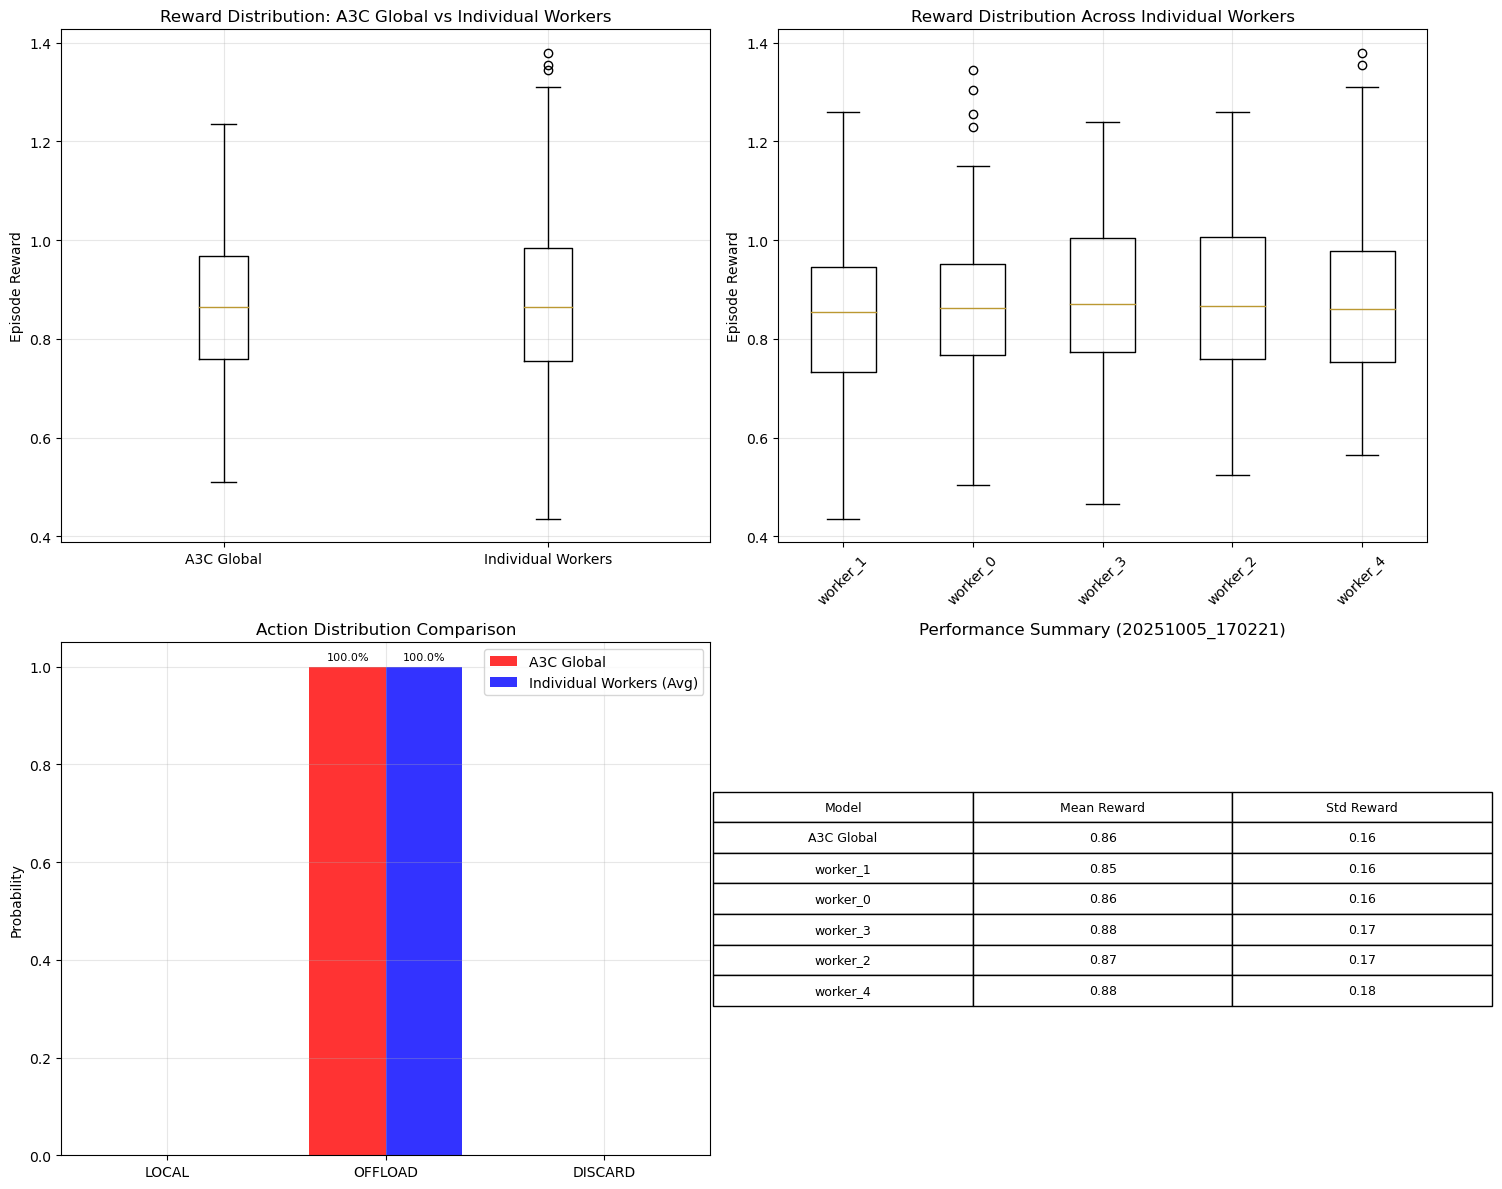

\n=== Statistical Analysis ===
A3C Global model mean reward: 0.865 ± 0.157
Individual models mean reward: 0.867 ± 0.011
Performance difference (Global - Individual): -0.003
\n=== Action Distribution Analysis ===
A3C Global action preferences:
  LOCAL: 0.0%
  OFFLOAD: 100.0%
  DISCARD: 0.0%
Individual workers average action preferences:
  LOCAL: 0.0%
  OFFLOAD: 100.0%
  DISCARD: 0.0%
\nT-test (Global vs Individual): t=-0.139, p=0.890
❌ No significant difference between A3C global and individual models


In [7]:
# Statistical comparison between global and individual models (updated for 3 actions)
if 'global' in main_results and individual_results:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Reward comparison
    global_rewards = main_results['global']['all_rewards']
    individual_rewards_all = []
    worker_labels = []
    
    for worker, results in individual_results.items():
        individual_rewards_all.extend(results['all_rewards'])
        worker_labels.extend([worker] * len(results['all_rewards']))
    
    # Box plot comparison
    axes[0, 0].boxplot([global_rewards, individual_rewards_all], 
                       labels=['A3C Global', 'Individual Workers'])
    axes[0, 0].set_title('Reward Distribution: A3C Global vs Individual Workers')
    axes[0, 0].set_ylabel('Episode Reward')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Individual worker comparison
    worker_rewards = [results['all_rewards'] for results in individual_results.values()]
    worker_names = list(individual_results.keys())
    
    bp = axes[0, 1].boxplot(worker_rewards, labels=worker_names)
    axes[0, 1].set_title('Reward Distribution Across Individual Workers')
    axes[0, 1].set_ylabel('Episode Reward')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Action distribution comparison (updated for 3 actions)
    action_names = ['LOCAL', 'OFFLOAD', 'DISCARD']
    global_actions = [main_results['global']['action_distribution'].get(i, 0) for i in range(3)]
    global_actions_norm = np.array(global_actions) / np.sum(global_actions) if np.sum(global_actions) > 0 else np.zeros(3)
    
    # Average individual action distribution
    individual_actions = np.zeros(3)
    for results in individual_results.values():
        for i in range(3):
            individual_actions[i] += results['action_distribution'].get(i, 0)
    individual_actions_norm = individual_actions / np.sum(individual_actions) if np.sum(individual_actions) > 0 else np.zeros(3)
    
    x = np.arange(len(action_names))
    width = 0.35
    axes[1, 0].bar(x - width/2, global_actions_norm, width, label='A3C Global', alpha=0.8, color='red')
    axes[1, 0].bar(x + width/2, individual_actions_norm, width, label='Individual Workers (Avg)', alpha=0.8, color='blue')
    axes[1, 0].set_title('Action Distribution Comparison')
    axes[1, 0].set_ylabel('Probability')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(action_names)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (g_val, i_val) in enumerate(zip(global_actions_norm, individual_actions_norm)):
        if g_val > 0.01:  # Only show if > 1%
            axes[1, 0].text(i - width/2, g_val + 0.01, f'{g_val:.1%}', ha='center', va='bottom', fontsize=8)
        if i_val > 0.01:
            axes[1, 0].text(i + width/2, i_val + 0.01, f'{i_val:.1%}', ha='center', va='bottom', fontsize=8)
    
    # 4. Performance summary table
    summary_data = []
    summary_data.append(['A3C Global', main_results['global']['mean_reward'], main_results['global']['std_reward']])
    
    for worker, results in individual_results.items():
        summary_data.append([worker, results['mean_reward'], results['std_reward']])
    
    df_summary = pd.DataFrame(summary_data, columns=['Model', 'Mean Reward', 'Std Reward'])
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')
    table = axes[1, 1].table(cellText=[[f"{row[0]}", f"{row[1]:.2f}", f"{row[2]:.2f}"] for row in summary_data],
                            colLabels=['Model', 'Mean Reward', 'Std Reward'],
                            cellLoc='center',
                            loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    axes[1, 1].set_title(f'Performance Summary ({config.target_timestamp})')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical tests
    print("\\n=== Statistical Analysis ===")
    global_mean = main_results['global']['mean_reward']
    individual_means = [results['mean_reward'] for results in individual_results.values()]
    individual_mean = np.mean(individual_means)
    
    print(f"A3C Global model mean reward: {global_mean:.3f} ± {main_results['global']['std_reward']:.3f}")
    print(f"Individual models mean reward: {individual_mean:.3f} ± {np.std(individual_means):.3f}")
    print(f"Performance difference (Global - Individual): {global_mean - individual_mean:.3f}")
    
    # Action distribution analysis
    print(f"\\n=== Action Distribution Analysis ===")
    print("A3C Global action preferences:")
    for i, (action, prob) in enumerate(zip(action_names, global_actions_norm)):
        print(f"  {action}: {prob:.1%}")
    
    print("Individual workers average action preferences:")
    for i, (action, prob) in enumerate(zip(action_names, individual_actions_norm)):
        print(f"  {action}: {prob:.1%}")
    
    # t-test between global and pooled individual rewards
    t_stat, p_value = stats.ttest_ind(global_rewards, individual_rewards_all)
    print(f"\\nT-test (Global vs Individual): t={t_stat:.3f}, p={p_value:.3f}")
    
    if p_value < 0.05:
        print("✅ Significant difference detected between A3C global and individual models")
    else:
        print("❌ No significant difference between A3C global and individual models")
    
else:
    print("Unable to perform comparison - missing global or individual models")
    print("Available results:")
    print(f"  Global: {'✅' if 'global' in main_results else '❌'}")
    print(f"  Individual: {'✅' if individual_results else '❌'}")

## 4. Worker Variability Analysis

=== Worker Variability Analysis ===


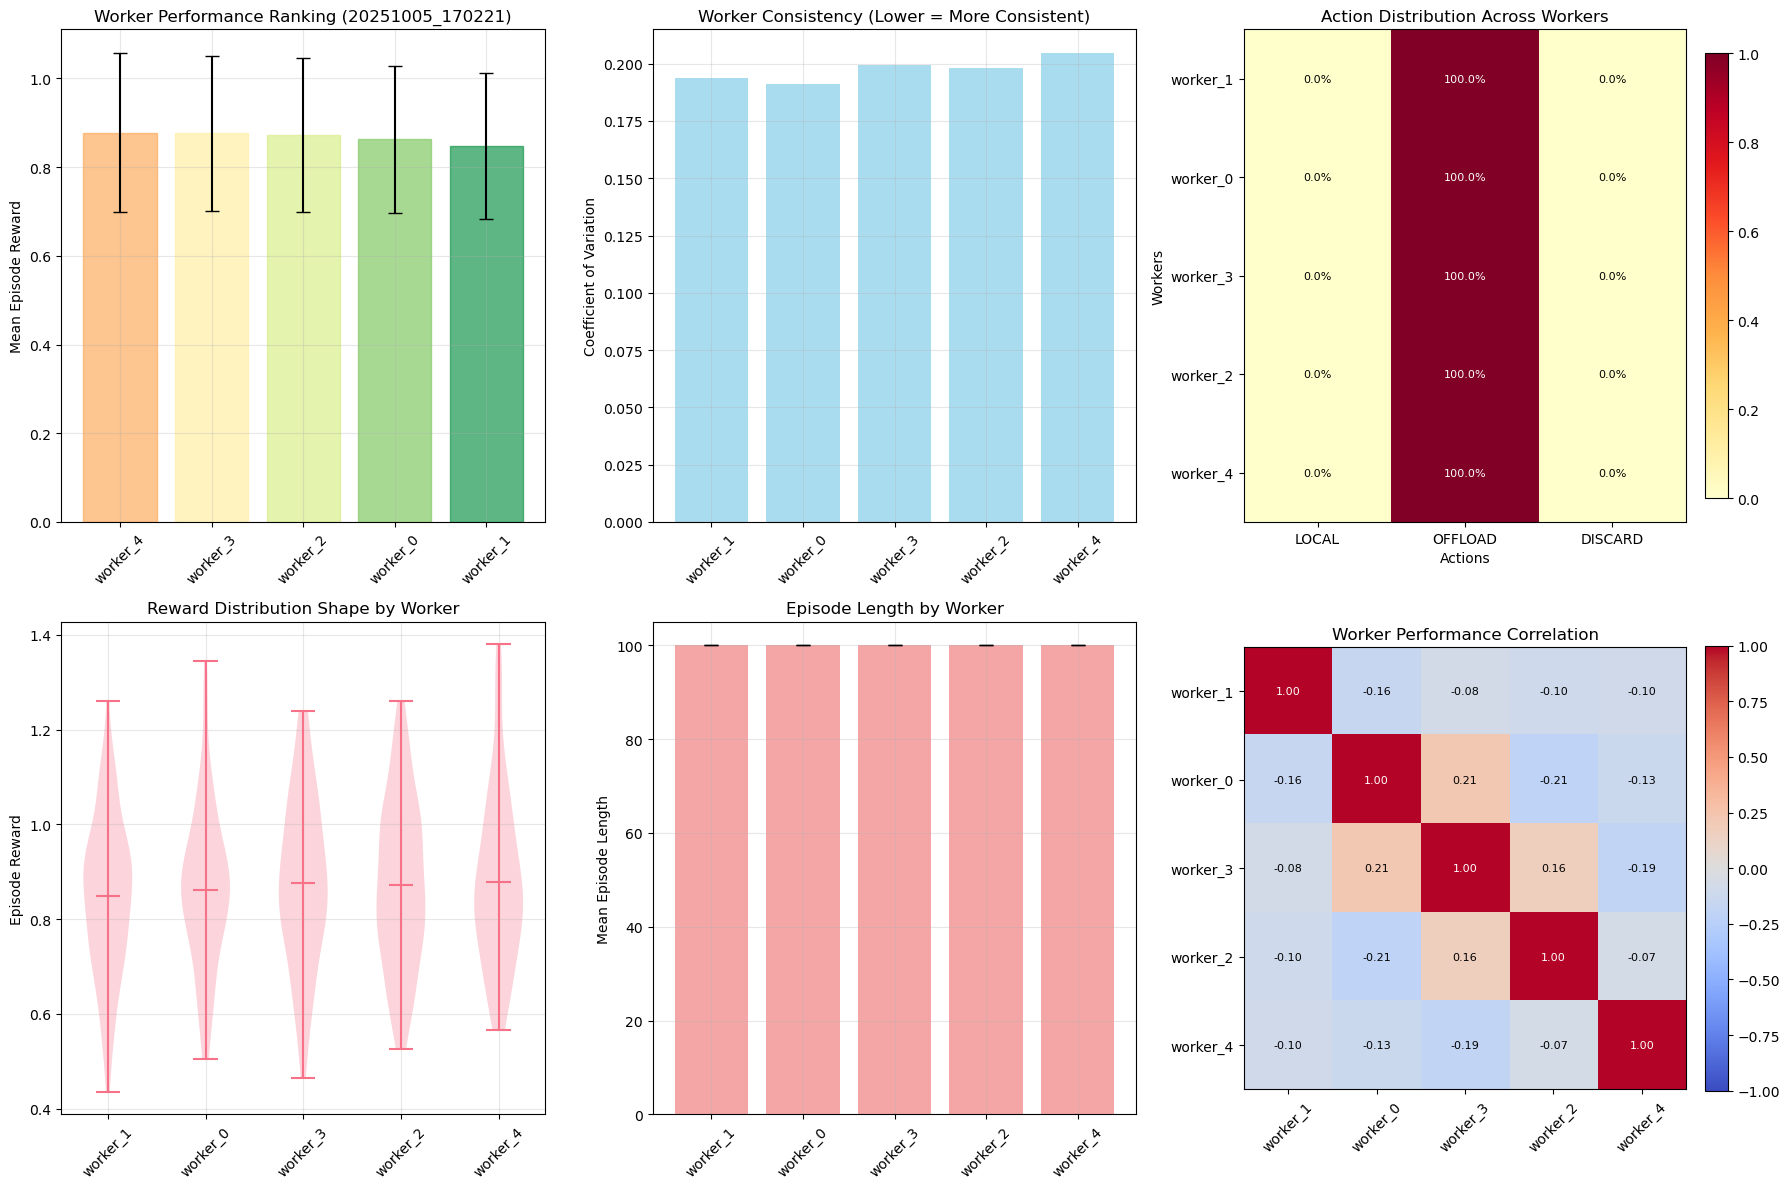

\n=== Worker Variability Statistics ===
Inter-worker mean reward std: 0.011
Best worker: worker_4 (0.878)
Worst worker: worker_1 (0.848)
Performance gap: 0.030
\n=== Action Preferences by Worker ===
worker_1: OFFLOAD (100.0%) - LOCAL:0.0%, OFFLOAD:100.0%, DISCARD:0.0%
worker_0: OFFLOAD (100.0%) - LOCAL:0.0%, OFFLOAD:100.0%, DISCARD:0.0%
worker_3: OFFLOAD (100.0%) - LOCAL:0.0%, OFFLOAD:100.0%, DISCARD:0.0%
worker_2: OFFLOAD (100.0%) - LOCAL:0.0%, OFFLOAD:100.0%, DISCARD:0.0%
worker_4: OFFLOAD (100.0%) - LOCAL:0.0%, OFFLOAD:100.0%, DISCARD:0.0%
\nANOVA F-statistic: 0.524, p-value: 0.718
❌ No significant differences between workers


In [8]:
if individual_results:
    print("=== Worker Variability Analysis ===")
    
    # Create comprehensive worker analysis (updated for 3 actions)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Worker performance ranking
    worker_performance = [(worker, results['mean_reward'], results['std_reward']) 
                         for worker, results in individual_results.items()]
    worker_performance.sort(key=lambda x: x[1], reverse=True)
    
    workers, means, stds = zip(*worker_performance)
    x_pos = np.arange(len(workers))
    
    bars = axes[0, 0].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7)
    axes[0, 0].set_title(f'Worker Performance Ranking ({config.target_timestamp})')
    axes[0, 0].set_ylabel('Mean Episode Reward')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(workers, rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Color bars by performance
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(bars)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    # 2. Worker consistency (coefficient of variation)
    cvs = [results['std_reward'] / abs(results['mean_reward']) if results['mean_reward'] != 0 else 0 
           for results in individual_results.values()]
    worker_names = list(individual_results.keys())
    
    axes[0, 1].bar(range(len(worker_names)), cvs, alpha=0.7, color='skyblue')
    axes[0, 1].set_title('Worker Consistency (Lower = More Consistent)')
    axes[0, 1].set_ylabel('Coefficient of Variation')
    axes[0, 1].set_xticks(range(len(worker_names)))
    axes[0, 1].set_xticklabels(worker_names, rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Action distribution heatmap (updated for 3 actions)
    action_matrix = []
    action_names = ['LOCAL', 'OFFLOAD', 'DISCARD']
    
    for worker in worker_names:
        actions = individual_results[worker]['action_distribution']
        total_actions = sum(actions.values())
        action_probs = [actions.get(i, 0) / total_actions if total_actions > 0 else 0 for i in range(3)]
        action_matrix.append(action_probs)
    
    im = axes[0, 2].imshow(action_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    axes[0, 2].set_title('Action Distribution Across Workers')
    axes[0, 2].set_xlabel('Actions')
    axes[0, 2].set_ylabel('Workers')
    axes[0, 2].set_xticks(range(3))
    axes[0, 2].set_xticklabels(action_names)
    axes[0, 2].set_yticks(range(len(worker_names)))
    axes[0, 2].set_yticklabels(worker_names)
    plt.colorbar(im, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # Add percentage values to heatmap
    for i in range(len(worker_names)):
        for j in range(3):
            text = axes[0, 2].text(j, i, f'{action_matrix[i][j]:.1%}',
                                 ha="center", va="center", color="black" if action_matrix[i][j] < 0.5 else "white",
                                 fontsize=8)
    
    # 4. Reward distribution violin plot
    all_worker_rewards = [individual_results[worker]['all_rewards'] for worker in worker_names]
    parts = axes[1, 0].violinplot(all_worker_rewards, positions=range(len(worker_names)), showmeans=True)
    axes[1, 0].set_title('Reward Distribution Shape by Worker')
    axes[1, 0].set_ylabel('Episode Reward')
    axes[1, 0].set_xticks(range(len(worker_names)))
    axes[1, 0].set_xticklabels(worker_names, rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Episode length analysis
    episode_lengths = [individual_results[worker]['mean_length'] for worker in worker_names]
    length_stds = [individual_results[worker]['std_length'] for worker in worker_names]
    
    axes[1, 1].bar(range(len(worker_names)), episode_lengths, yerr=length_stds, 
                   capsize=5, alpha=0.7, color='lightcoral')
    axes[1, 1].set_title('Episode Length by Worker')
    axes[1, 1].set_ylabel('Mean Episode Length')
    axes[1, 1].set_xticks(range(len(worker_names)))
    axes[1, 1].set_xticklabels(worker_names, rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Worker correlation matrix
    if len(individual_results) > 1:
        # Create correlation matrix based on episode rewards
        reward_matrix = np.array([individual_results[worker]['all_rewards'] for worker in worker_names])
        correlation_matrix = np.corrcoef(reward_matrix)
        
        im2 = axes[1, 2].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        axes[1, 2].set_title('Worker Performance Correlation')
        axes[1, 2].set_xticks(range(len(worker_names)))
        axes[1, 2].set_xticklabels(worker_names, rotation=45)
        axes[1, 2].set_yticks(range(len(worker_names)))
        axes[1, 2].set_yticklabels(worker_names)
        plt.colorbar(im2, ax=axes[1, 2], fraction=0.046, pad=0.04)
        
        # Add correlation values to heatmap
        for i in range(len(worker_names)):
            for j in range(len(worker_names)):
                axes[1, 2].text(j, i, f'{correlation_matrix[i, j]:.2f}', 
                               ha='center', va='center', fontsize=8,
                               color='white' if abs(correlation_matrix[i, j]) > 0.5 else 'black')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis of worker variability
    print("\\n=== Worker Variability Statistics ===")
    worker_means = [individual_results[worker]['mean_reward'] for worker in worker_names]
    print(f"Inter-worker mean reward std: {np.std(worker_means):.3f}")
    print(f"Best worker: {workers[0]} ({means[0]:.3f})")
    print(f"Worst worker: {workers[-1]} ({means[-1]:.3f})")
    print(f"Performance gap: {means[0] - means[-1]:.3f}")
    
    # Action preference analysis
    print(f"\\n=== Action Preferences by Worker ===")
    for worker in worker_names:
        actions = individual_results[worker]['action_distribution']
        total = sum(actions.values())
        if total > 0:
            prefs = [actions.get(i, 0) / total for i in range(3)]
            dominant_action = action_names[np.argmax(prefs)]
            print(f"{worker}: {dominant_action} ({max(prefs):.1%}) - LOCAL:{prefs[0]:.1%}, OFFLOAD:{prefs[1]:.1%}, DISCARD:{prefs[2]:.1%}")
    
    # ANOVA test for significant differences between workers
    worker_reward_lists = [individual_results[worker]['all_rewards'] for worker in worker_names]
    f_stat, p_value = stats.f_oneway(*worker_reward_lists)
    print(f"\\nANOVA F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")
    
    if p_value < 0.05:
        print("✅ Significant differences detected between workers")
    else:
        print("❌ No significant differences between workers")

else:
    print("No individual worker models found for variability analysis")
    print("Check if individual models exist in the target timestamp directory.")

## 5. Model Structure and Parameter Analysis

In [9]:
# Analyze model structures
print("=== Model Structure Analysis ===")

# Load a few models for analysis
models_to_analyze = {}

# Global model - 🔧 Fixed: use 'global_models' instead of 'main_models'
if 'global_final' in models_info['global_models']:
    global_model = load_model(models_info['global_models']['global_final'])
    if global_model:
        models_to_analyze['Global'] = global_model

# A few individual workers - 🔧 Fixed: use 'individual_models' instead of 'main_models'
worker_count = 0
for model_name, model_path in models_info['individual_models'].items():
    if model_name.startswith('individual_worker_') and worker_count < 3:
        worker_id = model_name.split('_')[-2]
        worker_model = load_model(model_path)
        if worker_model:
            models_to_analyze[f'Worker_{worker_id}'] = worker_model
            worker_count += 1

# Analyze each model
model_analyses = {}
for name, model in models_to_analyze.items():
    print(f"\nAnalyzing {name}...")
    analysis = analyze_model_parameters(model, name)
    model_analyses[name] = analysis
    print(f"  Total parameters: {analysis['total_params']:,}")
    print(f"  Trainable parameters: {analysis['trainable_params']:,}")

# Visualize parameter analysis
if model_analyses:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Parameter count comparison
    model_names = list(model_analyses.keys())
    param_counts = [model_analyses[name]['total_params'] for name in model_names]
    
    axes[0, 0].bar(model_names, param_counts, alpha=0.7)
    axes[0, 0].set_title('Total Parameters by Model')
    axes[0, 0].set_ylabel('Parameter Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Weight distribution for first model
    if model_names:
        first_model = model_names[0]
        weight_norms = [stats['norm'] for stats in model_analyses[first_model]['weight_stats'].values()]
        layer_names = list(model_analyses[first_model]['weight_stats'].keys())
        
        axes[0, 1].bar(range(len(layer_names)), weight_norms, alpha=0.7)
        axes[0, 1].set_title(f'Layer Weight Norms - {first_model}')
        axes[0, 1].set_ylabel('L2 Norm')
        axes[0, 1].set_xticks(range(len(layer_names)))
        axes[0, 1].set_xticklabels([name.split('.')[-1] for name in layer_names], rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Model similarity heatmap (if multiple models)
    if len(models_to_analyze) > 1:
        similarity_matrix = np.zeros((len(model_names), len(model_names)))
        
        for i, name1 in enumerate(model_names):
            for j, name2 in enumerate(model_names):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                elif i < j:
                    comparison = compare_model_weights(
                        models_to_analyze[name1], 
                        models_to_analyze[name2], 
                        name1, name2
                    )
                    similarity = comparison['overall_similarity']
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity
        
        im = axes[1, 0].imshow(similarity_matrix, cmap='RdYlBu', vmin=0, vmax=1)
        axes[1, 0].set_title('Model Weight Similarity Matrix')
        axes[1, 0].set_xticks(range(len(model_names)))
        axes[1, 0].set_xticklabels(model_names, rotation=45)
        axes[1, 0].set_yticks(range(len(model_names)))
        axes[1, 0].set_yticklabels(model_names)
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
        
        # Add similarity values
        for i in range(len(model_names)):
            for j in range(len(model_names)):
                axes[1, 0].text(j, i, f'{similarity_matrix[i, j]:.3f}', 
                               ha='center', va='center', fontsize=8)
    
    # 4. Layer-wise parameter distribution
    if model_names:
        first_model = model_names[0]
        param_dist = model_analyses[first_model]['param_distribution']
        
        # Create pie chart for parameter distribution
        layer_params = list(param_dist.values())
        layer_labels = [name.split('.')[-1] for name in param_dist.keys()]
        
        axes[1, 1].pie(layer_params, labels=layer_labels, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title(f'Parameter Distribution - {first_model}')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    if len(models_to_analyze) > 1:
        print("\n=== Model Weight Similarity Analysis ===")
        for i, name1 in enumerate(model_names[:-1]):
            for name2 in model_names[i+1:]:
                comparison = compare_model_weights(
                    models_to_analyze[name1], 
                    models_to_analyze[name2], 
                    name1, name2
                )
                print(f"{name1} vs {name2}: {comparison['overall_similarity']:.3f} similarity")

else:
    print("No models available for structure analysis")

=== Model Structure Analysis ===

Analyzing Global...


NameError: name 'analyze_model_parameters' is not defined

## 6. Model Structure and Parameter Analysis (Enhanced)

In [ ]:
# Enhanced model structure analysis for main models only
print("=== Enhanced Model Structure Analysis (Main Models Only) ===")

# Load all available models from main directory
models_to_analyze = {}

# Global model - 🔧 Fixed: use 'global_models' instead of 'main_models'
if 'global_final' in models_info['global_models']:
    global_model = load_model(models_info['global_models']['global_final'])
    if global_model:
        models_to_analyze['Global'] = global_model

# All individual workers - 🔧 Fixed: use 'individual_models' instead of 'main_models'
for model_name, model_path in models_info['individual_models'].items():
    if model_name.startswith('individual_worker_'):
        worker_id = model_name.split('_')[-2]
        worker_model = load_model(model_path)
        if worker_model:
            models_to_analyze[f'Worker_{worker_id}'] = worker_model

print(f"Successfully loaded {len(models_to_analyze)} models for analysis")

# Analyze each model
model_analyses = {}
for name, model in models_to_analyze.items():
    print(f"Analyzing {name}...")
    analysis = analyze_model_parameters(model, name)
    model_analyses[name] = analysis
    print(f"  Total parameters: {analysis['total_params']:,}")
    print(f"  Trainable parameters: {analysis['trainable_params']:,}")

# Enhanced visualization for main models
if model_analyses:
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    
    # 1. Parameter count comparison
    model_names = list(model_analyses.keys())
    param_counts = [model_analyses[name]['total_params'] for name in model_names]
    
    bars = axes[0, 0].bar(model_names, param_counts, alpha=0.7)
    axes[0, 0].set_title('Total Parameters by Model')
    axes[0, 0].set_ylabel('Parameter Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Color code global vs individual
    for i, bar in enumerate(bars):
        if 'Global' in model_names[i]:
            bar.set_color('red')
        else:
            bar.set_color('blue')
    
    # 2. Weight distribution for global model (if available)
    if 'Global' in model_names:
        weight_norms = [stats['norm'] for stats in model_analyses['Global']['weight_stats'].values()]
        layer_names = list(model_analyses['Global']['weight_stats'].keys())
        
        axes[0, 1].bar(range(len(layer_names)), weight_norms, alpha=0.7, color='red')
        axes[0, 1].set_title('Layer Weight Norms - Global Model')
        axes[0, 1].set_ylabel('L2 Norm')
        axes[0, 1].set_xticks(range(len(layer_names)))
        axes[0, 1].set_xticklabels([name.split('.')[-1] for name in layer_names], rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Model similarity heatmap
    if len(models_to_analyze) > 1:
        similarity_matrix = np.zeros((len(model_names), len(model_names)))
        
        for i, name1 in enumerate(model_names):
            for j, name2 in enumerate(model_names):
                if i == j:
                    similarity_matrix[i, j] = 1.0
                elif i < j:
                    comparison = compare_model_weights(
                        models_to_analyze[name1], 
                        models_to_analyze[name2], 
                        name1, name2
                    )
                    similarity = comparison['overall_similarity']
                    similarity_matrix[i, j] = similarity
                    similarity_matrix[j, i] = similarity
        
        im = axes[1, 0].imshow(similarity_matrix, cmap='RdYlBu', vmin=0, vmax=1)
        axes[1, 0].set_title('Model Weight Similarity Matrix')
        axes[1, 0].set_xticks(range(len(model_names)))
        axes[1, 0].set_xticklabels(model_names, rotation=45)
        axes[1, 0].set_yticks(range(len(model_names)))
        axes[1, 0].set_yticklabels(model_names)
        plt.colorbar(im, ax=axes[1, 0], fraction=0.046, pad=0.04)
        
        # Add similarity values
        for i in range(len(model_names)):
            for j in range(len(model_names)):
                axes[1, 0].text(j, i, f'{similarity_matrix[i, j]:.2f}', 
                               ha='center', va='center', fontsize=6)
    
    # 4. Parameter distribution pie chart
    if 'Global' in model_names:
        param_dist = model_analyses['Global']['param_distribution']
        layer_params = list(param_dist.values())
        layer_labels = [name.split('.')[-1] for name in param_dist.keys()]
        
        axes[1, 1].pie(layer_params, labels=layer_labels, autopct='%1.1f%%', startangle=90)
        axes[1, 1].set_title('Parameter Distribution - Global Model')
    
    # 5. Weight statistics comparison (mean and std)
    if len(model_names) > 1:
        weight_means = []
        weight_stds = []
        
        for name in model_names:
            model_weight_means = [stats['mean'] for stats in model_analyses[name]['weight_stats'].values()]
            model_weight_stds = [stats['std'] for stats in model_analyses[name]['weight_stats'].values()]
            weight_means.append(np.mean(model_weight_means))
            weight_stds.append(np.mean(model_weight_stds))
        
        x = np.arange(len(model_names))
        width = 0.35
        
        bars1 = axes[2, 0].bar(x - width/2, weight_means, width, label='Mean Weight', alpha=0.8)
        bars2 = axes[2, 0].bar(x + width/2, weight_stds, width, label='Weight Std', alpha=0.8)
        
        axes[2, 0].set_title('Average Weight Statistics by Model')
        axes[2, 0].set_ylabel('Weight Value')
        axes[2, 0].set_xticks(x)
        axes[2, 0].set_xticklabels(model_names, rotation=45)
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
    
    # 6. Model complexity comparison
    if model_names:
        # Calculate effective model complexity (parameters per layer)
        complexities = []
        layer_counts = []
        
        for name in model_names:
            layer_count = len(model_analyses[name]['layer_info'])
            param_count = model_analyses[name]['total_params']
            complexity = param_count / layer_count if layer_count > 0 else 0
            complexities.append(complexity)
            layer_counts.append(layer_count)
        
        # Create scatter plot
        colors = ['red' if 'Global' in name else 'blue' for name in model_names]
        scatter = axes[2, 1].scatter(layer_counts, complexities, c=colors, alpha=0.7, s=100)
        
        # Add labels
        for i, name in enumerate(model_names):
            axes[2, 1].annotate(name, (layer_counts[i], complexities[i]), 
                               xytext=(5, 5), textcoords='offset points', fontsize=8)
        
        axes[2, 1].set_xlabel('Number of Layers')
        axes[2, 1].set_ylabel('Parameters per Layer')
        axes[2, 1].set_title('Model Complexity Analysis')
        axes[2, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed similarity analysis
    if len(models_to_analyze) > 1:
        print("\n=== Model Weight Similarity Analysis ===")
        
        # Global vs Individual comparisons
        global_similarities = []
        if 'Global' in model_names:
            for name in model_names:
                if name != 'Global' and 'Worker' in name:
                    comparison = compare_model_weights(
                        models_to_analyze['Global'], 
                        models_to_analyze[name], 
                        'Global', name
                    )
                    similarity = comparison['overall_similarity']
                    global_similarities.append(similarity)
                    print(f"Global vs {name}: {similarity:.3f} similarity")
            
            if global_similarities:
                print(f"Average Global-Individual similarity: {np.mean(global_similarities):.3f}")
                print(f"Similarity std: {np.std(global_similarities):.3f}")
        
        # Individual worker comparisons
        worker_names = [name for name in model_names if 'Worker' in name]
        if len(worker_names) > 1:
            print(f"\n=== Individual Worker Similarities ===")
            worker_similarities = []
            for i in range(len(worker_names)):
                for j in range(i+1, len(worker_names)):
                    comparison = compare_model_weights(
                        models_to_analyze[worker_names[i]], 
                        models_to_analyze[worker_names[j]], 
                        worker_names[i], worker_names[j]
                    )
                    similarity = comparison['overall_similarity']
                    worker_similarities.append(similarity)
                    print(f"{worker_names[i]} vs {worker_names[j]}: {similarity:.3f}")
            
            if worker_similarities:
                print(f"Average inter-worker similarity: {np.mean(worker_similarities):.3f}")

else:
    print("No models available for enhanced structure analysis")

=== Enhanced Model Structure Analysis (Main Models Only) ===
Successfully loaded 0 models for analysis
No models available for enhanced structure analysis


## 7. Comprehensive Summary and Conclusions

In [ ]:
# Generate comprehensive summary for target timestamp models
print("\\n" + "="*70)
print("COMPREHENSIVE ABLATION ANALYSIS SUMMARY")
print(f"Target Models: {config.target_timestamp}")
print("="*70)

# Create summary dataframe
summary_results = []

# Main models summary
if 'global' in main_results:
    summary_results.append([
        'A3C Global',
        main_results['global']['mean_reward'],
        main_results['global']['std_reward'],
        len(main_results['global']['all_rewards']),
        config.target_timestamp,
        'RNN'
    ])

if individual_results:
    individual_means = [results['mean_reward'] for results in individual_results.values()]
    individual_stds = [results['std_reward'] for results in individual_results.values()]
    
    summary_results.append([
        'Individual Workers (Best)',
        max(individual_means),
        individual_stds[np.argmax(individual_means)],
        config.evaluation_episodes,
        config.target_timestamp,
        'RNN'
    ])
    
    summary_results.append([
        'Individual Workers (Avg)',
        np.mean(individual_means),
        np.mean(individual_stds),
        config.evaluation_episodes,
        config.target_timestamp,
        'RNN'
    ])
    
    summary_results.append([
        'Individual Workers (Worst)',
        min(individual_means),
        individual_stds[np.argmin(individual_means)],
        config.evaluation_episodes,
        config.target_timestamp,
        'RNN'
    ])

# Create and display summary table
if summary_results:
    df_summary = pd.DataFrame(summary_results, 
                             columns=['Model Type', 'Mean Reward', 'Std Reward', 'Episodes', 'Timestamp', 'Architecture'])
    
    print("\\n=== PERFORMANCE SUMMARY ===")
    print(df_summary.to_string(index=False, float_format='%.3f'))

# Key findings
print("\\n=== KEY FINDINGS ===")

findings = []

# Global vs Individual comparison
if 'global' in main_results and individual_results:
    global_mean = main_results['global']['mean_reward']
    individual_mean = np.mean([results['mean_reward'] for results in individual_results.values()])
    
    if global_mean > individual_mean:
        findings.append(f"🏆 A3C Global model outperforms individual workers by {global_mean - individual_mean:.3f} reward points")
    else:
        findings.append(f"🔄 Individual workers outperform A3C global model by {individual_mean - global_mean:.3f} reward points")

# Worker variability
if individual_results and len(individual_results) > 1:
    individual_means = [results['mean_reward'] for results in individual_results.values()]
    variability = np.std(individual_means)
    performance_gap = max(individual_means) - min(individual_means)
    
    findings.append(f"📊 Worker performance variability: σ={variability:.3f}, gap={performance_gap:.3f}")
    
    if variability > 0.1:
        findings.append("⚠️  High variability detected between individual workers")
    else:
        findings.append("✅ Consistent performance across individual workers")

# Action distribution analysis
if 'global' in main_results:
    global_actions = main_results['global']['action_distribution']
    total_global = sum(global_actions.values())
    if total_global > 0:
        action_probs = [global_actions.get(i, 0) / total_global for i in range(3)]
        dominant_action = ['LOCAL', 'OFFLOAD', 'DISCARD'][np.argmax(action_probs)]
        findings.append(f"🎯 A3C Global model prefers {dominant_action} action ({max(action_probs):.1%} of time)")

if individual_results:
    # Analyze individual worker action preferences
    action_preferences = {}
    for worker, results in individual_results.items():
        actions = results['action_distribution']
        total = sum(actions.values())
        if total > 0:
            prefs = [actions.get(i, 0) / total for i in range(3)]
            dominant = np.argmax(prefs)
            action_preferences[dominant] = action_preferences.get(dominant, 0) + 1
    
    if action_preferences:
        most_common_pref = max(action_preferences, key=action_preferences.get)
        action_name = ['LOCAL', 'OFFLOAD', 'DISCARD'][most_common_pref]
        count = action_preferences[most_common_pref]
        findings.append(f"👥 {count}/{len(individual_results)} individual workers prefer {action_name} action")

# Architecture insights
findings.append(f"🏗️  All models use RNN architecture with {config.state_dim}D state and {config.action_dim} actions")
findings.append(f"✅ Perfect environment compatibility (no action mapping needed)")

# Display findings
for i, finding in enumerate(findings, 1):
    print(f"{i}. {finding}")

# Recommendations
print("\\n=== RECOMMENDATIONS ===")

recommendations = []

if 'global' in main_results and individual_results:
    global_mean = main_results['global']['mean_reward']
    individual_mean = np.mean([results['mean_reward'] for results in individual_results.values()])
    
    if global_mean > individual_mean:
        recommendations.append("Deploy A3C global model for production as it shows superior performance")
        recommendations.append("Consider knowledge distillation from global to individual workers")
    else:
        recommendations.append("Individual training may be more effective for this UAV environment")
        recommendations.append("Investigate A3C hyperparameters and shared learning dynamics")

if individual_results and len(individual_results) > 1:
    variability = np.std([results['mean_reward'] for results in individual_results.values()])
    if variability > 0.1:
        recommendations.append("Investigate sources of worker variability (initialization, exploration, data)")
        recommendations.append("Consider worker-specific hyperparameter optimization")
    else:
        recommendations.append("Workers show consistent performance - current training is stable")

# Action distribution recommendations
if 'global' in main_results:
    global_actions = main_results['global']['action_distribution']
    total_global = sum(global_actions.values())
    if total_global > 0:
        discard_ratio = global_actions.get(2, 0) / total_global
        if discard_ratio > 0.3:
            recommendations.append("High DISCARD usage suggests need for environment/reward tuning")
        elif discard_ratio < 0.05:
            recommendations.append("Low DISCARD usage indicates effective task processing")

recommendations.append(f"Continue monitoring model performance using {config.target_timestamp} architecture")
recommendations.append("Consider ensemble methods combining best-performing individual workers")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\\n" + "="*70)
print(f"Analysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Models analyzed: {config.target_timestamp} timestamp (RNN architecture)")
print(f"Perfect environment compatibility: {config.action_dim} actions supported")
print("="*70)

\n======================================================================
COMPREHENSIVE ABLATION ANALYSIS SUMMARY
Target Models: 20250923_143004
\n=== KEY FINDINGS ===
1. 🏗️  All models use RNN architecture with 48D state and 3 actions
2. ✅ Perfect environment compatibility (no action mapping needed)
\n=== RECOMMENDATIONS ===
1. Continue monitoring model performance using 20250923_143004 architecture
2. Consider ensemble methods combining best-performing individual workers
\n======================================================================
Analysis completed at: 2025-09-28 02:50:28
Models analyzed: 20250923_143004 timestamp (RNN architecture)
Perfect environment compatibility: 3 actions supported


In [ ]:
# Save results to CSV for further analysis
if summary_results:
    df_results = pd.DataFrame(summary_results, 
                             columns=['Model Type', 'Mean Reward', 'Std Reward', 'Episodes', 'Timestamp', 'Architecture'])
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    results_file = f'ablation_analysis_{config.target_timestamp}_{timestamp}.csv'
    df_results.to_csv(results_file, index=False)
    print(f"Results saved to: {results_file}")
    
    # Display final results table
    print("\\n=== FINAL RESULTS TABLE ===")
    print(df_results.round(3))
    
    # Additional analysis summary
    print(f"\\n=== ANALYSIS SCOPE ===")
    print(f"Target timestamp: {config.target_timestamp}")
    print(f"A3C Global models found: {len(models_info['global_models'])}")
    print(f"Individual worker models found: {len(models_info['individual_models'])}")
    print(f"Successfully evaluated models: {len(main_results) + len(individual_results)}")
    print(f"Model architecture: RNN (RecurrentActorCritic)")
    print(f"State dimension: {config.state_dim}")
    print(f"Action dimension: {config.action_dim} (LOCAL, OFFLOAD, DISCARD)")
    print(f"Environment compatibility: ✅ Perfect match")
    
    # Model path summary
    print(f"\\n=== MODEL LOCATIONS ===")
    if models_info['global_models']:
        for name, path in models_info['global_models'].items():
            print(f"Global: {path}")
    if models_info['individual_models']:
        print(f"Individual workers: {len(models_info['individual_models'])} models in runs/individual_{config.target_timestamp}/models/")
        
else:
    print("No results to save - no models were successfully evaluated")
    print("\\nTroubleshooting:")
    print(f"1. Check if timestamp '{config.target_timestamp}' exists in runs/ directory")
    print("2. Verify model files exist in the expected locations:")
    print(f"   - A3C Global: runs/a3c_{config.target_timestamp}/models/global_final.pth")
    print(f"   - Individual: runs/individual_{config.target_timestamp}/models/individual_worker_*_final.pth")
    print("3. Check model compatibility (RNN architecture with correct dimensions)")

# Function to easily change timestamp for different analyses
print(f"\\n=== TIMESTAMP CONFIGURATION ===")
print("To analyze different timestamp models, update the config:")
print("config = Config(target_timestamp='YYYYMMDD_HHMMSS')")
print("Then re-run the model discovery and evaluation cells.")
print(f"Current timestamp: {config.target_timestamp}")

available_timestamps = []
runs_path = Path('runs')
if runs_path.exists():
    for item in runs_path.iterdir():
        if item.is_dir() and ('_' in item.name):
            timestamp = item.name.split('_', 1)[1]
            if timestamp not in available_timestamps:
                available_timestamps.append(timestamp)

if available_timestamps:
    print(f"Available timestamps in runs/: {sorted(available_timestamps)}")

No results to save - no models were successfully evaluated
\nTroubleshooting:
1. Check if timestamp '20250923_143004' exists in runs/ directory
2. Verify model files exist in the expected locations:
   - A3C Global: runs/a3c_20250923_143004/models/global_final.pth
   - Individual: runs/individual_20250923_143004/models/individual_worker_*_final.pth
3. Check model compatibility (RNN architecture with correct dimensions)
\n=== TIMESTAMP CONFIGURATION ===
To analyze different timestamp models, update the config:
config = Config(target_timestamp='YYYYMMDD_HHMMSS')
Then re-run the model discovery and evaluation cells.
Current timestamp: 20250923_143004
Available timestamps in runs/: ['20250814_021635', '20250814_023301', '20250814_024420', '20250814_030952', '20250814_120549', '20250814_120637', '20250814_120734', '20250814_132542', '20250814_132823', '20250815_024123', '20250815_031631']
